# 모듈, 레이어 및 모델 소개

머신러닝 TensorFlow를 수행하려면 모델을 정의, 저장 및 복원해야 할 수 있음

모델 ?
- 텐서에서 무언가를 계산하는 함수 (정방향)
- 훈련에 대한 응답으로 업데이트할 수 있는 일부 변수

In [1]:
import tensorflow as tf
from datetime import datetime

# 현재 폴더에 logs 폴더에 기록
%load_ext tensorboard

## TensorFlow에서 모델 및 레이어 정의하기

`tf.Module`

- 대부분의 모델은 레이어로 구성
- 레이어 : 재사용, 훈련 가능한 변수를 가진 수학적 구조의 함수
    - Keras 또는 Sonnet과 같은 레이어 및 모델 상위 수준 구현은 이 클래스를 기반으로 구축

In [2]:
# 스칼라 텐서에서 동작하는 매우 간단한 tf.Module
class SimpleModule(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.a_variable = tf.Variable(5.0, name="train_me")  # tf.Variable : 값 변경이 가능한 변수
        self.non_trainable_variable = tf.Variable(5.0, trainable=False, name="do_not_train_me")
    
    # 원하는 함수를 모델로 호출 가능
    def __call__(self, x):
        return self.a_variable * x + self.non_trainable_variable

simple_module = SimpleModule(name="simple")
simple_module(tf.constant(5.0))

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [3]:
# All trainable variables
print("trainable variables:", simple_module.trainable_variables)

# Every variable
print("all variables:", simple_module.variables)

trainable variables: (<tf.Variable 'train_me:0' shape=() dtype=float32, numpy=5.0>,)
all variables: (<tf.Variable 'train_me:0' shape=() dtype=float32, numpy=5.0>, <tf.Variable 'do_not_train_me:0' shape=() dtype=float32, numpy=5.0>)


- `tf.keras.layers.Layer` 및 `tf.keras.Model`의 기본 클래스이므로 여기에 표시되는 모든 항목도 Keras에 적용


- `tf.Module`을 하위 클래스화 함으로써, 이 객체의 속성에 할당된 `tf.Variable` 또는 `tf.Module` 인스턴스가 자동으로 수집됨. 이를 통해, 변수를 저장하고 업로드 할 수 있고, `tf.Module` 모음을 만들 수 있음

모듈로 구성된 2개 레이어 선형 레이어 모델

In [4]:
# 밀집 (선형) 레이어
class Dense(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name='w')
        self.b = tf.Variable(tf.zeros([out_features]), name='b')
    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)

# 두 개의 레이어 인스턴스를 만들고 적용하는 전체 모델
class SequentialModule(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)

        self.dense_1 = Dense(in_features=3, out_features=3)
        self.dense_2 = Dense(in_features=3, out_features=2)

    def __call__(self, x):
        x = self.dense_1(x)
        return self.dense_2(x)

# 모델 만들기
my_model = SequentialModule(name="the_model")

# 모델 결과 -> 랜덤 값
print("Model results:", my_model(tf.constant([[2.0, 2.0, 2.0]])))

Model results: tf.Tensor([[0.        3.0256922]], shape=(1, 2), dtype=float32)


- `tf.Module` 인스턴스는 `tf.Variable` 또는 할당된 `tf.Module` 인스턴스를 재귀적으로 자동 수집. 단일 모델 인스턴스로 `tf.Module` 모음을 관리하고 전체 모델을 저장하고 로드할 수 있음

In [5]:
print("Submodules:", my_model.submodules)

Submodules: (<__main__.Dense object at 0x0000026536C345E0>, <__main__.Dense object at 0x0000026536DAA6A0>)


In [6]:
for var in my_model.variables:
    print(var, "\n")

<tf.Variable 'b:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)> 

<tf.Variable 'w:0' shape=(3, 3) dtype=float32, numpy=
array([[ 0.5434053 , -1.0995396 , -0.21144496],
       [-0.24034368,  1.9589524 , -0.5495944 ],
       [ 0.37318102,  0.70389444,  0.2470009 ]], dtype=float32)> 

<tf.Variable 'b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)> 

<tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
array([[-1.0227125 , -0.10517052],
       [-0.9902278 ,  1.0132153 ],
       [ 0.93535393, -0.29339275]], dtype=float32)> 



### 변수 생성 연기하기

- 레이어에 대한 입력 및 출력 크기를 모두 정의해야 함. w 변수가 알려진 형상을 가지므로 할당할 수 있음


- 특정 입력 형상으로 모듈이 처음 호출될 때까지 변수 생성을 연기하면 입력 크기를 미리 지정할 필요 없음


- 이러한 유연성으로 인해, TensorFlow 레이어는 `tf.keras.layers.Dense`에서와 같이 출력의 형상을 지정하면 됨

In [7]:
class FlexibleDenseModule(tf.Module):
    # Note: No need for `in_features`
    def __init__(self, out_features, name=None):
        super().__init__(name=name)
        self.is_built = False
        self.out_features = out_features

    def __call__(self, x):
        # Create variables on first call.
        if not self.is_built:
            self.w = tf.Variable(
                tf.random.normal([x.shape[-1], self.out_features]), name='w')
            self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
            self.is_built = True

        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)

In [8]:
# Used in a module
class MySequentialModule(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        
        self.dense_1 = FlexibleDenseModule(out_features=3)
        self.dense_2 = FlexibleDenseModule(out_features=2)

    def __call__(self, x):
        x = self.dense_1(x)
        return self.dense_2(x)

my_model = MySequentialModule(name="the_model")
print("Model results:", my_model(tf.constant([[2.0, 2.0, 2.0]])))

Model results: tf.Tensor([[3.4010122 0.7497617]], shape=(1, 2), dtype=float32)


## 가중치 저장하기

`tf.Module`을 checkpoint와 SaveModel로 모두 저장할 수 있음

* 체크포인트
    - 가중치 (즉, 모듈 및 하위 모듈 내부의 변수 세트 값)
    - 데이터, 메타데이터용 인덱스 파일 두 가지로 구성
        - 데이터 : 변수 값, 해당 속성 조회 경로 포함
        - 인덱스 파일 : 실제 저장된 항목과 체크포인트의 번호 추적
    - 내부 살펴보기 : `list_variables(chkp_path)`


* 이때, 분산(다중 머신) 훈련 중에는 변수 모음이 샤딩될 수 있으므로 번호가 매겨짐 (예: '00000-of-00001'). But, 이 경우에는 샤드가 하나만 있음


* 모델을 다시 로드하면 Python 객체의 값을 덮어씀


* cf) `tf.checkpoint.CheckpointManager` : 체크포인트 관리를 쉽게 만들어주는 도우미 클래스

In [9]:
chkp_path = "my_checkpoint"
checkpoint = tf.train.Checkpoint(model=my_model)
checkpoint.write(chkp_path)

'my_checkpoint'

In [10]:
ls my_checkpoint*

 D 드라이브의 볼륨: 로컬 디스크
 볼륨 일련 번호: 96DD-2BDE

 D:\TIL\Deep Learning\TensorFlow(2.x) Guide 디렉터리

2023-04-14  오후 09:09               459 my_checkpoint.data-00000-of-00001
2023-04-14  오후 09:09               362 my_checkpoint.index
               2개 파일                 821 바이트
               0개 디렉터리  182,716,502,016 바이트 남음


In [11]:
tf.train.list_variables(chkp_path)

[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('model/dense_1/b/.ATTRIBUTES/VARIABLE_VALUE', [3]),
 ('model/dense_1/w/.ATTRIBUTES/VARIABLE_VALUE', [3, 3]),
 ('model/dense_2/b/.ATTRIBUTES/VARIABLE_VALUE', [2]),
 ('model/dense_2/w/.ATTRIBUTES/VARIABLE_VALUE', [3, 2])]

In [12]:
new_model = MySequentialModule()
new_checkpoint = tf.train.Checkpoint(model=new_model)
new_checkpoint.restore("my_checkpoint")

# Should be the same result as above
new_model(tf.constant([[2.0, 2.0, 2.0]]))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[3.4010122, 0.7497617]], dtype=float32)>

## 함수 저장하기

* TensorFlow는 원래 Python 객체 없이 모델 실행할 수 있음
    - Python에 설명된 계산을 수행하는 방법을 알아야 하지만, 원본 코드는 없음
    - 그래서 그래프 및 함수 소개 가이드에 설명된 그래프를 만들 수 있음
  
  
* 내가 만든 모듈은 이전과 똑같이 작동. 함수에 전달된 각 고유 서명은 별도의 그래프 생성

In [13]:
class MySequentialModule(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)

        self.dense_1 = Dense(in_features=3, out_features=3)
        self.dense_2 = Dense(in_features=3, out_features=2)
    
    # tf.function 데코레이터를 사용하여 위 모델에서 그래프 정의 가능
    @tf.function
    def __call__(self, x):
        x = self.dense_1(x)
        return self.dense_2(x)

# You have made a model with a graph!
my_model = MySequentialModule(name="the_model")

In [14]:
print(my_model([[2.0, 2.0, 2.0]]))
print(my_model([[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0]]]))

tf.Tensor([[0.27506474 0.        ]], shape=(1, 2), dtype=float32)
tf.Tensor(
[[[0.27506474 0.        ]
  [0.27506474 0.        ]]], shape=(1, 2, 2), dtype=float32)


* TensorBoard 요약 내에서 그래프 추적하여 그래프 시각화 가능

In [15]:
# logging 세팅
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "logs/func/%s" % stamp
writer = tf.summary.create_file_writer(logdir)

# 새로운 모델 Create, 그렇지 않으면 요약된 그래프 볼 수 없음
new_model = MySequentialModule()

# Bracket(텍스트 에디터) the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True)         # 그래프 추가
tf.profiler.experimental.start(logdir)   # 프로파일러 시작 및 중지

# Call only one tf.function when tracing.
z = print(new_model(tf.constant([[2.0, 2.0, 2.0]])))
with writer.as_default():
    tf.summary.trace_export(
        name="my_func_trace",
        step=0,
        profiler_outdir=logdir)

tf.Tensor([[0. 0.]], shape=(1, 2), dtype=float32)


Tensorboard를 실행해 결과 추적을 확인

In [16]:
#docs_infra: no_execute
%tensorboard --logdir logs/func

### SavedModel 생성하기

* 완전히 훈련된 모델 공유 권장 방법 : `SaveModel` (함수, 가중치 모두 포함)

In [20]:
# 방금 학습한 모델 저장 가능
tf.saved_model.save(my_model, "the_saved_model")

INFO:tensorflow:Assets written to: the_saved_model\assets


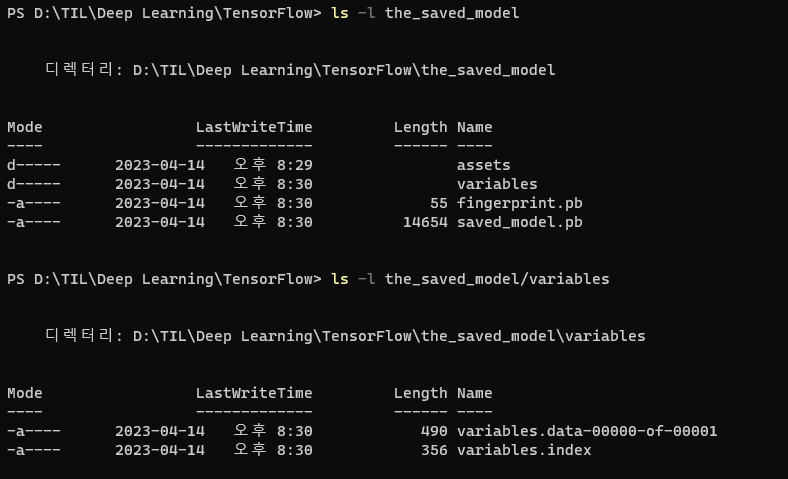

`save_model.pb` 파일은 함수형 `tf.Graph`를 설명하는 프로토콜 버퍼


- 모델과 레이어는 실제로 이 표현을 생성한 클래스의 인스턴스를 만들지 않고도 이 표현에서 로드 가능 (Python 코드 사용하지 못할 때 유용)


- 모델을 새 객체로 로드 가능 : `tf.saved_model.load("the_saved_model")`
    - new_model은 클래스 지식이 없는 내부 TensorFlow 사용자 객체
        - *SequentialModule* 유형이 아님!
        - 새 모델은 이미 정의된 입력 서명에서 동작하므로, 복원된 모델에 더 많은 서명 추가 불가능
        
        
- 아무튼! `SavedModel`을 사용하면 `tf.Module`을 사용하여 TensorFlow 가중치와 그래프 저장 후 다시 로드 가능하다 !!

In [24]:
new_model = tf.saved_model.load("the_saved_model")

In [25]:
isinstance(new_model, SequentialModule)

False

In [26]:
print(my_model([[2.0, 2.0, 2.0]]))
print(my_model([[[2.0, 2.0, 2.0], [2.0, 2.0, 2.0]]]))

tf.Tensor([[0.        3.7478333]], shape=(1, 2), dtype=float32)
tf.Tensor(
[[[0.        3.7478333]
  [0.        3.7478333]]], shape=(1, 2, 2), dtype=float32)


## Keras 모델 및 레이어

### Keras 레이어

`tf.keras.layers.Layer` : 모든 Keras 레이어의 기본 클래스이며, `tf.Module`에서 상속

In [27]:
class MyDense(tf.keras.layers.Layer):
    # Adding **kwargs to support base Keras layer arguments
    def __init__(self, in_features, out_features, **kwargs):
        super().__init__(**kwargs)

        # This will soon move to the build step; see below
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name='w')
        self.b = tf.Variable(tf.zeros([out_features]), name='b')
    
    # 부모 교체 후 __call__을 call로 변경하여 모듈을 Keras 레이어로 변환 가능
    def call(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)

simple_layer = MyDense(name="simple", in_features=3, out_features=3)

In [28]:
simple_layer([[2.0, 2.0, 2.0]])
# 결과: 기능엔 차이 없음

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.        , 0.        , 0.75114375]], dtype=float32)>

### build 단계

* 함수 정의 단계


* `build`는 정확히 한 번만 호출되며, 입력 형상으로 호출됨. 일반적으로 변수(가중치) 만드는데 사용


* 위의 `MyDense` 레이어를 입력 크기에 맞게 다시 작성 가능

In [29]:
class FlexibleDense(tf.keras.layers.Layer):
    # Note the added `**kwargs`, as Keras supports many arguments
    def __init__(self, out_features, **kwargs):
        super().__init__(**kwargs)
        self.out_features = out_features

    def build(self, input_shape):  # Create the state of the layer (weights)
        self.w = tf.Variable(
          tf.random.normal([input_shape[-1], self.out_features]), name='w')
        self.b = tf.Variable(tf.zeros([self.out_features]), name='b')

    def call(self, inputs):  # Defines the computation from inputs to outputs
        return tf.matmul(inputs, self.w) + self.b

# Create the instance of the layer
flexible_dense = FlexibleDense(out_features=3)

In [30]:
# 모델 빌드 안되어서 변수 없음
flexible_dense.variables

[]

In [31]:
# 함수 호출하면 적절한 크기의 변수 할당
print("Model results:", flexible_dense(tf.constant([[2.0, 2.0, 2.0], [3.0, 3.0, 3.0]])))

Model results: tf.Tensor(
[[-1.905567   9.027017   2.591538 ]
 [-2.8583503 13.540524   3.887307 ]], shape=(2, 3), dtype=float32)


In [32]:
flexible_dense.variables

[<tf.Variable 'flexible_dense/w:0' shape=(3, 3) dtype=float32, numpy=
 array([[-0.45107567,  3.1063793 , -0.9482329 ],
        [-0.27918908,  0.48973504,  1.01694   ],
        [-0.22251873,  0.9173938 ,  1.2270619 ]], dtype=float32)>,
 <tf.Variable 'flexible_dense/b:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [33]:
# `build`는 한 번만 호출되므로, 입력 형상이 레이어 변수와 호환안되면 입력이 거부됨
try:
    print("Model results:", flexible_dense(tf.constant([[2.0, 2.0, 2.0, 2.0]])))
except tf.errors.InvalidArgumentError as e:
    print("Failed:", e)

Failed: Exception encountered when calling layer 'flexible_dense' (type FlexibleDense).

{{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [1,4], In[1]: [3,3] [Op:MatMul]

Call arguments received by layer 'flexible_dense' (type FlexibleDense):
  • inputs=tf.Tensor(shape=(1, 4), dtype=float32)


cf) Keras 레이어의 더 많은 기능 (https://www.tensorflow.org/guide/keras/custom_layers_and_models?hl=ko)

- 선택적 손실
- 메트릭 지원
- 훈련 및 추론 사용을 구분하기 위한 선택적 training 인수에 대한 기본 지원
- Python에서 모델 복제를 허용하도록 구성을 정확하게 저장할 수 있는 get_config 및 from_config 메서드

### Keras 모델

` tf.keras.Model`

- 완전한 기능을 갖춘 모델 클래스 제공


- `tf.keras.layers.Layer`에서 상속되므로 Keras 모델은 Keras 레이어와 마찬가지로 사용, 중첩, 저장 가능 (모델을 중첩된 Keras 레이어로 정의할 수 있음)


- Keras 모델에는 쉽게 훈련, 평가, 로드 및 저장하고, 심지어 여러 머신에서 훈련할 수 있는 추가 기능이 있음

거의 동일한 코드로 위에서 `SequentialModule`을 정의할 수 있으며, 다시 __call__을 call()로 변환하고 부모를 변환할 수 있음

In [34]:
class MySequentialModel(tf.keras.Model):
    def __init__(self, name=None, **kwargs):
        super().__init__(**kwargs)

        self.dense_1 = FlexibleDense(out_features=3)
        self.dense_2 = FlexibleDense(out_features=2)
        
    def call(self, x):
        x = self.dense_1(x)
        return self.dense_2(x)

# 케라스 모델 만들 수 있음 !
my_sequential_model = MySequentialModel(name="the_model")

# Call it on a tensor, with random results
print("Model results:", my_sequential_model(tf.constant([[2.0, 2.0, 2.0]])))

Model results: tf.Tensor([[ 1.2106328 -1.5425544]], shape=(1, 2), dtype=float32)


In [35]:
# Keras 레이어 중첩
my_sequential_model.variables

[<tf.Variable 'my_sequential_model/flexible_dense_1/w:0' shape=(3, 3) dtype=float32, numpy=
 array([[-0.1592884 , -1.2919457 ,  0.74933535],
        [-0.9470681 ,  1.6291081 , -0.44126073],
        [ 0.20496644,  0.34732628,  1.2738811 ]], dtype=float32)>,
 <tf.Variable 'my_sequential_model/flexible_dense_1/b:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'my_sequential_model/flexible_dense_2/w:0' shape=(3, 2) dtype=float32, numpy=
 array([[ 0.19834481, -0.6172716 ],
        [-1.9494656 , -0.17068535],
        [ 1.3391585 , -0.7654118 ]], dtype=float32)>,
 <tf.Variable 'my_sequential_model/flexible_dense_2/b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

In [36]:
my_sequential_model.submodules

(<__main__.FlexibleDense at 0x2db66af6bb0>,
 <__main__.FlexibleDense at 0x2db67068190>)

`tf.keras.Model` 재정의

- TensorFlow 모델을 빌드하는 Python다운 접근 방식 (다름 프레임워크 모델을 마이그레이션하는 경우, 매우 간단할 수 있음)

- 기존 레이어와 입력을 간단하게 조합한 모델을 구성하는 경우, 모델 재구성 및 아키텍처와 관련된 추가 기능과 함께 제공되는 함수형 API를 사용하여 시간 절약 가능 (아래 예시 확인)

    - 가장 큰 차이는 입력 형상이 함수형 구성 프로세스의 일부로 저장된다는 것
    - 이 경우, input_shape를 완전히 지정할 필요 없고, 일부 차원은 None으로 남겨둘 수 있음

In [37]:
inputs = tf.keras.Input(shape=[3,])

x = FlexibleDense(3)(inputs)
x = FlexibleDense(2)(x)

my_functional_model = tf.keras.Model(inputs=inputs, outputs=x)

my_functional_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 flexible_dense_3 (FlexibleD  (None, 3)                12        
 ense)                                                           
                                                                 
 flexible_dense_4 (FlexibleD  (None, 2)                8         
 ense)                                                           
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [38]:
my_functional_model(tf.constant([[2.0, 2.0, 2.0]]))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-5.548208 ,  3.0216465]], dtype=float32)>

## Keras 모델 저장하기

모듈 `tf.saved_models.save()`을 사용하여 모델 저장 가능

- 다시 쉽게 로드할 수도 있고, `SavedModels`은 메트릭, 손실, 옵티마이저 상태를 저장함


- 이 재구성된 모델을 사용할 수 있으며, 같은 데이터로 호출될 때 같은 결과를 생성함

In [39]:
my_sequential_model.save("exname_of_file")

INFO:tensorflow:Assets written to: exname_of_file\assets


In [40]:
reconstructed_model = tf.keras.models.load_model("exname_of_file")

In [41]:
reconstructed_model(tf.constant([[2.0, 2.0, 2.0]]))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 1.2106328, -1.5425544]], dtype=float32)>